# Módulo: MODELOS DE INTELIGENCIA ARTIFICIAL
## Ejercicio práctico 1.
## Sistema Basado en Reglas   
### Análisis de la calidad del aire

De forma similar a lo realizado en el notebook SBR_IRIS, construye un sistema de clasificación de la calidad del aire (AirQuality - AQI) en función de la cantidad de Ozono detectado en el mismo.   
Los valores del nivel de AQI se muestran en la siguiente tabla:  


| NIVEL AQI | RANGO-DESCRIPCIÓN|
|:---------:|:----------------:|
|   BUENO   |     0 - 50       |
| MODERADO  |    51 - 100      |
|CONTAMINADO|   101 - 150      |
|  INSANO   |   151 - 200      |
| PELIGROSO |       > 200      |

Se pide intentar establecer la clasificación según la tabla anterior en base a alguna de las características que conforman el dataset (Valor de O2, Valor de CO, Valor de NO2, Valor de PM2.5, Longitud y Latitud).   
Como los datos son numéricos y no faltan valores, no se requiere ningún procesamiento previo.   

Nuestro objetivo es predecir el AQI, por lo que esta tarea sería de clasificación o de regresión, pero en este caso vamos a tratar de establecer un SBR basado en una de las variables independientes citadas.

<u>Nota sobre la característica ***PM2.5***</u> :   
Este valor se corresponde con la concentración del material particulado (*PM - Particulate Matter*) de la fracción de tamaño PM2,5 (2.5 micrometros), el cúal se encuentra íntimamente asociado a problemas de salud dado que entre sus efectos aparecen impactos claros sobre las enfermedades cardiacas y pulmonares.   

### 1. Importación del dataset

In [99]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
# Ocultamos los warnings de las librerías
import warnings
warnings.filterwarnings("ignore")
# ------------------------------------------------

Cargamos dataset *airquality.csv*

In [100]:
# Cargamos el dataset
data = pd.read_csv('datasets/airquality.csv')

Mostramos los primeros registros

In [101]:
data.head()

,AQI Value,CO AQI Value,Ozone AQI Value,NO2 AQI Value,PM2.5 AQI Value,lat,lng
0,51,1,36,0,51,44.7444,44.2031
1,41,1,5,1,41,-5.2900,-44.4900
2,41,1,5,1,41,-11.2958,-41.9869
3,66,1,39,2,66,37.1667,15.1833
4,34,1,34,0,20,53.0167,20.8833


#### 1.1 Asignación de Niveles AQI
Se define una función para mapear los valores de AQI a sus niveles cualitativos:

In [102]:
#Funcion de mapeo
def asignar_nivel_agi(row):
    aqi = row['AQI Value']
    if aqi <= 50:
        return'BUENO'
    elif aqi <= 100:
        return "MODERADO"
    elif aqi <= 150:
        return "CONTAMINADO"
    elif aqi <= 200:
        return "INSANO"
    else:
        return "PELIGROSO"

data['AQI Level'] = data.apply(asignar_nivel_agi, axis=1)
data

,AQI Value,CO AQI Value,Ozone AQI Value,NO2 AQI Value,PM2.5 AQI Value,lat,lng,AQI Level
0,51,1,36,0,51,44.7444,44.2031,MODERADO
1,41,1,5,1,41,-5.2900,-44.4900,BUENO
2,41,1,5,1,41,-11.2958,-41.9869,BUENO
3,66,1,39,2,66,37.1667,15.1833,MODERADO
4,34,1,34,0,20,53.0167,20.8833,BUENO
...,...,...,...,...,...,...,...,...
16690,54,1,34,5,54,37.5516,-77.3285,MODERADO
16691,71,1,39,1,71,49.0650,18.9219,MODERADO
16692,71,1,39,1,71,36.3385,-88.8513,MODERADO
16693,50,1,20,5,50,48.7786,2.2906,BUENO


Esto nos permite comparar posteriormente los valores predichos por el SBR con los valores reales.

### 2.Análisis breve del dataset (EDA)

Se analizan las distribuciones de los valores de los contaminantes y su relación con AQI Value.
En azul tenemos el AQI Value y en rojo cada una de las columnas con las que las comparamos.

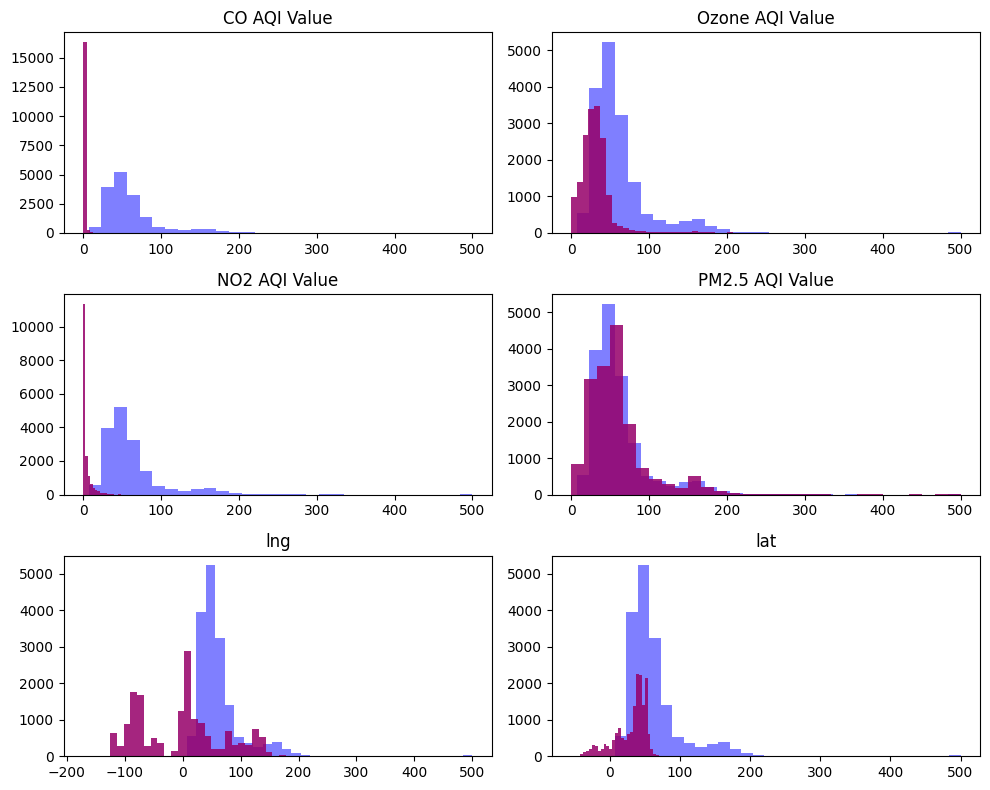

In [103]:
#Vemos primero los datos de AQI de los diferentes componentes del aire para ver si podemos extraer un dato clave
columns = ["CO AQI Value", "Ozone AQI Value", "NO2 AQI Value", "PM2.5 AQI Value", "lng", "lat"]

fig, axs = plt.subplots(3, 2, figsize=(10, 8))

for index, column in enumerate(columns):
    ax = axs[index // 2, index % 2]
    ax.hist(data[column], bins=30, color="blue", alpha=0.7)
    ax.set_title(column)
    ax.hist(data["AQI Value"], bins=30, alpha=0.5, label="AQI Value", color="blue")
    ax.hist(data[column], bins=30, alpha=0.5, label=f"{column} vs AQI Value", color="red")


plt.tight_layout()
plt.show()

Podemos ver como la gráfica que mas se parece a la de AQI VALUE es la de PM2.5, se ve como coinciden practicamente en todos lo spuntos, y como es incluso la unica que sigue esa "cola" que tiene la gráfica de AQI VALUE la cual es muy distintiva y seguramente nos ayude en valores mas altos, con lo cual sabemos que en detectar si la calidad del aire es "PELIGROSO" el usar PM 2.5 nos dará una precision increible. Lo cual coincide con la descripcion de lo que es el PM 2.5 como se ha comentado antes en el enunciado.
Tambien podemos ver como el Ozono si que tambien se parece, pero realmente no se ajusta tan bien.

##### Matriz de correlación
Hacemos una matriz de correlación para ver porcentajes de relacion entre variables

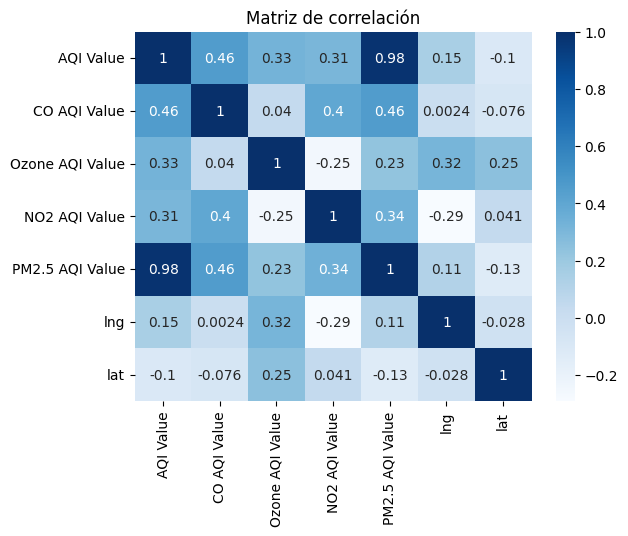

In [104]:
columns[:0]=["AQI Value"]
corr_matrix = data[columns].corr()
sns.heatmap(corr_matrix, annot=True, cmap="Blues")
plt.title("Matriz de correlación")
plt.show()


Nos enfocamos unicamente en PM 2.5 porque como vemos tiene un 98% de relacion con el AQI VALUE, ademas de ser un un contaminante fuertemente asociado a problemas cardiopulmonares

El PM2.5 muestra una correlación del 98% con AQI Value, por lo que se selecciona como variable clave para definir nuestra regla en el SBR.

### 3.Definición de reglas

Dado que PM2.5 AQI Value tiene una relación lineal con AQI Value, se utiliza directamente para clasificar los niveles de AQI.

In [105]:
def clasificar_nivel_de_aire(pm25):
    if pm25 <= 50:
        return "Nodo 1 (BUENO)"
    elif pm25 <= 100:
        return "Nodo 2 (MODERADO)"
    elif pm25 <= 150:
        return "Nodo 3 (CONTAMINADO)"
    elif pm25 <= 200:
        return "Nodo 4 (INSANO)"
    else:
        return "Nodo 5 (PELIGROSO)"

def asignar_nodo(row):
    return clasificar_nivel_de_aire(row['PM2.5 AQI Value'])

#### 3.1.Aplicación de reglas

Aplicamos la regla a todo el dataset estableciendo así nuestros nodos.

In [106]:
data['nodo'] = data.apply(asignar_nodo,axis=1)

#Vemos los nodos finales que nos quedan
nodos_finales = data['nodo'].unique()
nodos_finales

array(['Nodo 2 (MODERADO)', 'Nodo 1 (BUENO)', 'Nodo 4 (INSANO)',
       'Nodo 5 (PELIGROSO)', 'Nodo 3 (CONTAMINADO)'], dtype=object)

### 4.Visualización gráfica

Hacemos un a visualización grafica del sistema, viendo que ha detectado cada nodo.

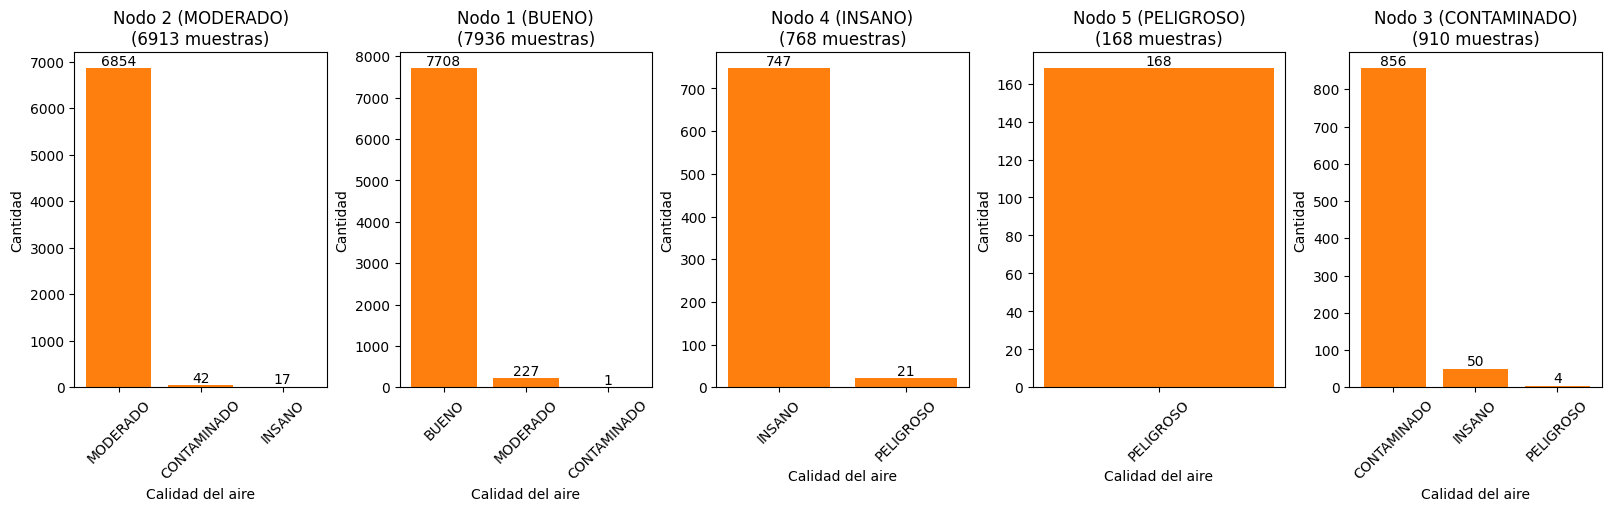

In [107]:
fig, axes = plt.subplots(1, len(nodos_finales), figsize=(16, 5), constrained_layout=True)

for ax, nodo in zip(axes, nodos_finales):
    nodo_data = data[data['nodo'] == nodo]
    aqi_level = nodo_data['AQI Level'].value_counts()
    bars = ax.bar(aqi_level.index, aqi_level.values)
    
    for bar in bars:
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            height,
            str(height), 
            ha='center', va='bottom', fontsize=10 
        )
    
    ax.bar(aqi_level.index, aqi_level.values)
    ax.set_title(f"{nodo}\n({len(nodo_data)} muestras)")
    ax.set_xlabel("Calidad del aire")
    ax.set_ylabel("Cantidad")
    ax.set_xticklabels(aqi_level.index, rotation=45)

Vemos que tal y como esperabamos cuanto mas alto es el valor mejor lo detecta, tal y como vimos en la grafica del principio, ya que el Pm 2.5 es altamente eficiente para detectar peligrosidad

#### Matriz de Confusión

Para evaluar el rendimiento del SBR se crea una matriz de confusión:

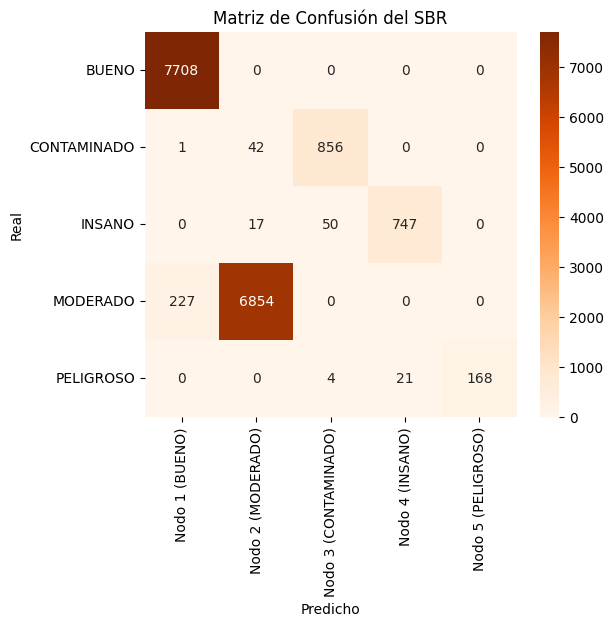

In [109]:

matriz_confusion = pd.crosstab(
    data["AQI Level"], 
    data["nodo"],  
    rownames=['Real'],
    colnames=['Predicho']
)

plt.figure(figsize=(6,5))
sns.heatmap(matriz_confusion, annot=True, cmap="Oranges", fmt='d')
plt.title("Matriz de Confusión del SBR")
plt.show()

El cálculo de precisión muestra que el modelo tiene una alta exactitud, ya que los valores predichos son cercanos a los valores reales.

Detectamos que en valores bajos es donde mas fallo hay, esto se podria mejorar a futuro usando otras variables para afinar el comportamiento en estos valores mas bajos.

### 3. Conclusiones y mejoras

#### 3.1 Conclusiones

- Hemos conseguido un buen resultado unicamente con una variable.
- Hemos logrado definir mejoras a futuro.
- Hemos implementado con exito el SBR.

#### 3.2 Mejoras

- Uso de más variables: Aunque PM2.5 tiene una alta correlación con AQI Value, se podrían usar otras variables para poder afinar el comportamiento y aumentar aun mas la precision.
- Mejora de la regla: Se pueden ajustar los valores de los rangos para optimizar la clasificación.
- Validación con más datos: Probar el modelo en diferentes regiones o con más datos históricos para validar su efectividad.